# Spring 2020 - IEOR4718 - Prof. Emanuel Derman

# Binomial Trees Using Object Oriented Programming


The LocalVolTree class has been inspired by **C++ Design Patterns and Derivatives Pricing by Mark Joshi**, which explains how to implement a Binomial Tree Class (using Object Oriented Programming) for the case of constant volatility.

This notebook adapts Mark Joshi's classes for local volatilities $\sigma(t, S)$. The stock then follows the following SDE:

$$ \cfrac{dS}{S} = r\: dt + \sigma(t, S)\: dZ $$

## Table of Content

1. Imports
2. Tree Option Classes
    See BinomialTreeModels notebook. Same implementation.
3. Local Volatility Tree Class
4. Examples of use
    1. Valuation of a put on a local volatility tree over 4 time steps. 
    2. Valuation of a call on a local volatility tree over 5 time steps.
    3. What is a smile when the stock follows a Local Volatility model?
    4. Case where an option has no BSM implied volatility under a Local Volatility model.




## Imports

In [90]:
import numpy as np
import pandas as pd
import BSM as bsm
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy

mpl.style.use("seaborn")

## Tree Option Classes (copy-paste of BinomialTreeModels notebook)

Pricing options on trees has little to do with general option concepts using elsewhere. The most important difference is the need of a *valueAtNode* function, which, given the spot price, the current time and the future discounted value of the option, compute the value of the option at a given node. 

Therefore, TreeOption classes are implemented, which will make the pricing of options easy on any tree. 

The design is inspried by Mark Joshi, which allows any option. Not only traditional European and American options, but exotic one as well, say a Barrier Option that can be exercised only but only in a specific timeframe. 

### Abstract Class

In [49]:
class TreeAbstractOption:
    
    def __init__(self, maturity, payoff):
        
        self.T = maturity
        self.payoff = payoff
        
    
    def valueAtNode(self, time, spot, discountedFutureValue):
        pass

### European Tree Options

In [50]:
class TreeEuropeanOption(TreeAbstractOption):
    
    def __init__(self, maturity, payoff):
        
        TreeAbstractOption.__init__(self, maturity, payoff)
        
    
    def valueAtNode(self, time, spot, discountedFutureValue):
        
        return discountedFutureValue

### European Knock-Out Barrier Tree Options

In [52]:
class TreeKnockOutBarrierOption(TreeAbstractOption):
    
    def __init__(self, vanillaOption, barrier, kind='up'):
        
        TreeAbstractOption.__init__(self, vanillaOption.T, vanillaOption.payoff)
        self.B = barrier
        
        if kind in ['u', 'up']:
            self.isOut = lambda S : S >= self.B
        elif kind in ['d', 'down']:
            self.isOut = lambda S : S <= self.B
    
    
    def valueAtNode(self, time, spot, discountedFutureValue):
        
        if self.isOut(spot):
            return 0
        else:
            return discountedFutureValue

### American Tree Options

In [53]:
class TreeAmericanOption(TreeAbstractOption):
    
    def __init__(self, maturity, payoff):
        
        TreeAbstractOption.__init__(self, maturity, payoff)
    
    
    def valueAtNode(self, time, spot, discountedFutureValue):
        
        return max(self.payoff(spot), discountedFutureValue)

# Systematic Tree Class for (t, S)-dependent volatility

In [3]:
class LocalVolTree:
    
    def __init__(self, spot, rates, sigma, n_steps, maturity):
        
        # TODO: handle dividends, and rates/dividends curve (as in Mark Joshi's class)
        self.S0 = spot
        self.r = rates
        self.sigma = sigma
        self.T = maturity
        
        self.N = n_steps
        self.dt = maturity / n_steps
        
        self.hasBeenBuilt = False
        
    
    def _build(self): # protected method
        
        # Compute the discount factors
        self.discounts = np.exp( - self.r * self.dt ) * np.ones(self.N+1)
        
        # Initialization of the trees
        self.treeStock = np.ones( (self.N+1, self.N+1) )
        self.treeVol = np.zeros( (self.N+1, self.N+1) )
        self.treeOption = np.zeros( (self.N+1, self.N+1) )
        self.treeProbRN = np.zeros( (self.N+1, self.N+1) )
        self.treeStock[0, 0] = self.S0
        self.treeVol[0, 0] = self.sigma(0, self.S0)
        
        # Definition of handy functions:
        isEven = lambda i : ( i % 2 == 0 )
        isOdd = lambda i : not( isEven(i) )
        
        spineSu = lambda time, S : S * np.exp( self.sigma( time, S ) * np.sqrt( self.dt ) )
        spineSd = lambda time, S : S * np.exp( -self.sigma( time, S ) * np.sqrt( self.dt ) )
    
        
        # Loop across all layers
        for i in range(1, self.N+1):
            
            currentTime = i * self.dt
            
            # Initialization of the spine
            if isEven(i):
                # If #layer is even, the number of nodes is odd and we initialize the middle node as S0
                
                self.treeStock[i, int(i/2)] = self.S0
                
                firstIndexAbove = int(i/2) + 1
                firstIndexBelow = int(i/2) - 1
            
            elif isOdd(i):
                # If #layer is odd, the number of nodes is even and we need to initialize two values. 
                # We use the "handy functions" defined above
                
                self.treeStock[i, int(i/2)] = spineSd(currentTime, self.S0)
                self.treeStock[i, int(i/2) + 1] = spineSu(currentTime, self.S0)
                
                firstIndexAbove = int(i/2) + 2
                firstIndexBelow = int(i/2) - 1
            
            
            # Above the spine: known S, Sd, F; unknown Su
            for j in range(firstIndexAbove, i+1):
                
                S = self.treeStock[i-1, j-1]
                Sd = self.treeStock[i, j-1]
                F = S * np.exp( self.r * self.dt )
                
                # Compute Su from S, Sd and F
                Su = (S**2) * (self.treeVol[i-1, j-1]**2) * self.dt
                Su /= F - Sd
                Su += F
                
                self.treeStock[i, j] = Su
            
            
            # Below the spine: known S, Su, F; unknown Sd
            for j in range(firstIndexBelow, -1, -1):
                
                S = self.treeStock[i-1, j]
                Su = self.treeStock[i, j+1]
                F = S * np.exp( self.r * self.dt )
                
                # Compute Su from S, Sd and F
                Sd = - (S**2) * (self.treeVol[i-1, j]**2) * self.dt
                Sd /= Su - F
                Sd += F
                
                self.treeStock[i, j] = Sd
            
            
            # Compute the local volatilities of this layer
            for j in range(0, i+1):
                self.treeVol[i, j] = self.sigma(currentTime, self.treeStock[i, j])
                
            # Compute the risk-neutral probilities of the previous layer
            for j in range(0, i):
                F = self.treeStock[i-1, j] * np.exp( self.r * self.dt )
                Sd, Su = self.treeStock[i, j:j+2]
                self.treeProbRN[i-1, j] = (F - Sd) / (Su - Sd)
        
        # End of loop across all layers
    
    
    
    def getValue(self, option:TreeAbstractOption): 
        # gets the value of the option at time 0 by binomial tree valuation (backward-induction)
        
        # If the tree has yet to be built, we build it
        if not(self.hasBeenBuilt):
            self._build()

        # Initialization: at maturity the value is the payoff of the option
        for k in range(0, self.N+1):
            self.treeOption[self.N, k] = option.payoff( self.treeStock[self.N, k] )
        
        # Backward Induction with Risk-Neutral probability
        for i in range(self.N-1, -1, -1):
                
            currentTime = i * self.dt
                
            for j in range(0, i+1):
                
                spot = self.treeStock[i, j]
                    
                # Future discounted value:
                q = self.treeProbRN[i, j]
                Cd, Cu = self.treeOption[i+1,j:j+2]
                discountedFutureValue = q * Cu + (1-q) * Cd
                discountedFutureValue *= self.discounts[i]
                    
                # Option's value at node: ( for Vanilla European Options this is the discountedFutureValue )
                self.treeOption[i, j] = option.valueAtNode(currentTime, spot, discountedFutureValue)
        
        return self.treeOption[0, 0]

## Tools

### Print each tree of the Tree Class

In [4]:
def printTree(which, TREE):
    
    if which in ["s", "stock"]:
        df = pd.DataFrame( TREE.treeStock )
    elif which in ["v", "vol", "volatility"]:
        df = pd.DataFrame( TREE.treeVol )
    elif which in ["o", "option"]:
        df = pd.DataFrame( TREE.treeOption )
    elif which in ["p", "proba", "probaRN"]:
        df = pd.DataFrame( TREE.treeProbRN )
    
    df.index *= TREE.dt
    
    for i in range(len(df)):
        for j in range(i+1, len(df[0])):
            df.iloc[i, j] = np.nan
    
    return df.round(2)

# Examples of use

This section is the solution I submitted of the Homework 7 of IEOR4718 in the Spring of 2020. The problem set's copyright is to Prof. Emanuel Derman. 


## Problem 1

The local volatility function is defined as $ \sigma(t, S) = 0.2 - \left( \cfrac{S}{100} - 1 \right)$.

We want to price a put with maturity 0.04, strike 98 on a local volatility tree with time step 0.01 (i.e. 1+4 layers). 

**Assumptions:**
- rates = 50% a year compounded continuously
- dividends = 0
- S = 100
- K = 98
- T = 0.04 year

In [59]:
sigma = lambda t, S : 0.2 - ( S / 100 - 1)
put = TreeEuropeanOption(0.04, lambda S : max(0, 98-S)) 
tree = LocalVolTree(100, 0.5, sigma_p1, 4, 0.04)

In [60]:
value = tree.getValue(put)

## Question 1: show the stock tree and probability tree

### The Stock tree

In [61]:
printTree("stock", tree)

,0,1,2,3,4
0.00,100.00,NaN,NaN,NaN,NaN
0.01,98.02,102.02,NaN,NaN,NaN
0.02,95.39,100.00,103.86,NaN,NaN
0.03,93.31,98.02,102.02,105.57,NaN
0.04,89.94,95.39,100.00,103.86,107.14


### The Probability tree

In [62]:
printTree("proba", tree)

,0,1,2,3,4
0.00,0.62,NaN,NaN,NaN,NaN
0.01,0.68,0.66,NaN,NaN,NaN
0.02,0.54,0.62,0.66,NaN,NaN
0.03,0.70,0.68,0.66,0.68,NaN
0.04,0.00,0.00,0.00,0.00,0.0


## Question 2: compute the value of a put struck at 98

In [64]:
value = tree.getValue(put)
print("The value of the put is approximately ${:.2f}".format(value))

The value of the put is approximately $0.43


## Question 3: compute the implied CRR volatility

In [66]:
def f(sigma):
    tmpTree = LocalVolTree(100, 0.5, lambda t, S : sigma, 4, 0.04)
    
    return tmpTree.getValue(put) - value

impliedCRR = round(100*scipy.optimize.newton(f, 0.3), 0)
print("The CRR implied volatility is approximately {:.0f}%".format(impliedCRR))

The CRR implied volatility is approximately 21%


# Problem 2

The local volatility function is defined as $ \sigma(t, S) = 0.2 - \left( \cfrac{S}{100} - 1 \right)$.

We want to price a call with maturity 0.05, strike 100 on a local volatility tree with time step 0.01 (i.e. 1+5 layers). 

**Assumptions:**
- rates and dividends are 0
- S = 100
- K = 100
- T = 0.05 year

## Question: value a call struck at 100 and show the coresponding trees

In [68]:
sigma = lambda t, S : 0.2 - ( S / 100 - 1)
call = TreeEuropeanOption(0.05, lambda S : max(0, S-100))
tree = LocalVolTree(100, 0, sigma, 5, 0.05)

In [69]:
value = tree.getValue(call)

### The Stock tree

In [71]:
printTree("stock", tree)

,0,1,2,3,4,5
0.00,100.00,NaN,NaN,NaN,NaN,NaN
0.01,98.02,102.02,NaN,NaN,NaN,NaN
0.02,95.68,100.00,103.69,NaN,NaN,NaN
0.03,93.37,98.02,102.02,105.40,NaN,NaN
0.04,90.69,95.68,100.00,103.69,106.78,NaN
0.05,88.05,93.37,98.02,102.02,105.40,108.23


### The Probability tree

In [72]:
printTree("proba", tree)

,0,1,2,3,4,5
0.00,0.50,NaN,NaN,NaN,NaN,NaN
0.01,0.54,0.55,NaN,NaN,NaN,NaN
0.02,0.50,0.50,0.49,NaN,NaN,NaN
0.03,0.54,0.54,0.55,0.55,NaN,NaN
0.04,0.50,0.50,0.50,0.49,0.49,NaN
0.05,0.00,0.00,0.00,0.00,0.00,0.0


### The Volatility tree

In [73]:
printTree("vol", tree)

,0,1,2,3,4,5
0.00,0.20,NaN,NaN,NaN,NaN,NaN
0.01,0.22,0.18,NaN,NaN,NaN,NaN
0.02,0.24,0.20,0.16,NaN,NaN,NaN
0.03,0.27,0.22,0.18,0.15,NaN,NaN
0.04,0.29,0.24,0.20,0.16,0.13,NaN
0.05,0.32,0.27,0.22,0.18,0.15,0.12


### The Call Option's valuation tree

In [75]:
printTree("option", tree)

,0,1,2,3,4,5
0.00,1.87,NaN,NaN,NaN,NaN,NaN
0.01,0.93,2.82,NaN,NaN,NaN,NaN
0.02,0.27,1.50,3.92,NaN,NaN,NaN
0.03,0.00,0.54,2.47,5.40,NaN,NaN
0.04,0.00,0.00,1.00,3.69,6.78,NaN
0.05,0.00,0.00,0.00,2.02,5.40,8.23


In [77]:
print("The value of the call option is approximately ${:.2f}".format(value))

The value of the call option is approximately $1.87


# Problem 3

The local volatility function is defined as $ \sigma(t, S) = 0.2 \: e^{-2\:\left( \cfrac{S}{100} - 1 \right)}$.

We want to graph the smile given by this local volatility function.

**Assumptions:**
- rates and dividends are 0
- S = 100
- K from 95 to 105
- T = 1/2 year

In [78]:
strikes = np.arange(95, 106, 1)

sigma = lambda t, S : 0.2 * np.exp( -2 * ( S / 100 - 1) ) 
tree = LocalVolTree(100, 0, sigma, n_steps=100, maturity=0.5)

def makeCall(K):
    
    return TreeEuropeanOption(1, lambda S : max(0, S-K))


In [80]:
callOptions = [ makeCall(K) for K in strikes ]
callPrices = [ tree.getValue(call) for call in callOptions ]

## Compute the implied volatilities

In [81]:
impliedVolatilities = [
    bsm.call.implied_volatility( price, 100, K, 0, 0.5 ) for price, K in zip(callPrices, STRIKES)
]

In [87]:
df = pd.DataFrame(impliedVolatilities, columns=["Implied Volatility (%)"], index=STRIKES)
df *= 100
df.round(0).astype(int)

,Implied Volatility (%)
95,21
96,21
97,21
98,20
99,20
100,20
101,20
102,20
103,19
104,19


## Graph the smile

(18.75, 21.25)

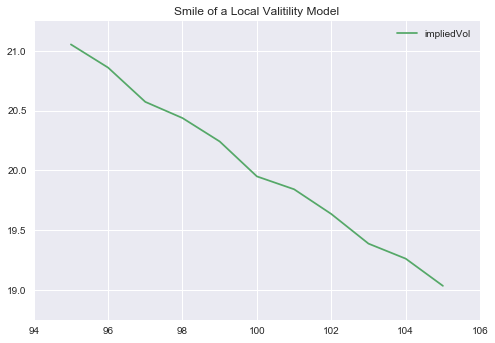

In [101]:
plt.plot(strikes, 100*np.array(impliedVolatilities), label="impliedVol", color='C1')
plt.title("Smile of a Local Valitility Model")
plt.legend()
plt.xlim(94, 106)
plt.ylim(18.75, 21.25)

# Problem 4


The local volatility function is defined as $ \sigma(t, S) = 0.1\: e^{-3\: \left( \cfrac{S}{100} - 1 \right) }$.

We want to value a up-and-out barrier call option and find its BSM implied volatility. 

In this problem, our implementation will still work. Howeber, we will need a trick to make use of it. We will make as if the payoff of knock-out barrier options is always the payoff of their underlying vanilla option, whatever the path of the stock is. This is not true of course, but the valuation algorithm on a binomial tree will still work if we say that the option is worthless for every node where the spot is beyond the barrier (in our case above 120).

**Assumptions:**
- rates and dividends are 0
- S = 100
- K = 105
- B = 120
- T = 1 year

In [105]:
sigma = lambda t, S : 0.1 * np.exp( -3 * ( S / 100 - 1) ) 

call = TreeEuropeanOption(1, lambda S : max(0, S-105))
barrier = TreeKnockOutBarrierOption(call, 120, "up")
tree = LocalVolTree(100, 0, sigma, n_steps=80, maturity=1)

In [107]:
value = tree.getValue(barrier)

## Valuation of the barrier option using implied volatility

### The Stock Tree

In [108]:
printTree("stock", tree)

,0,1,2,3,4,5,6,7,8,9,...,71,72,73,74,75,76,77,78,79,80
0.0000,100.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.0125,98.89,101.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.0250,97.71,100.00,102.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.0375,96.55,98.89,101.12,103.26,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.0500,95.32,97.71,100.00,102.19,104.28,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.9500,-0.11,-0.06,-0.02,0.02,0.06,0.12,0.20,0.33,0.52,0.82,...,144.35,145.20,146.03,146.84,147.64,148.43,NaN,NaN,NaN,NaN
0.9625,-0.12,-0.06,-0.02,0.02,0.06,0.11,0.17,0.28,0.43,0.67,...,143.94,144.80,145.64,146.46,147.26,148.05,148.83,NaN,NaN,NaN
0.9750,-0.18,-0.11,-0.06,-0.02,0.02,0.06,0.12,0.20,0.33,0.52,...,143.49,144.35,145.20,146.03,146.84,147.64,148.43,149.20,NaN,NaN
0.9875,-0.21,-0.12,-0.06,-0.02,0.02,0.06,0.11,0.17,0.28,0.43,...,143.07,143.94,144.80,145.64,146.46,147.26,148.05,148.83,149.59,NaN


## The Option Tree

In [110]:
printTree("option", tree)

,0,1,2,3,4,5,6,7,8,9,...,71,72,73,74,75,76,77,78,79,80
0.0000,1.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.0125,1.39,1.87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.0250,1.16,1.60,2.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.0375,0.96,1.36,1.85,2.4,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.0500,0.78,1.13,1.58,2.1,2.68,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.9500,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.0,0.00,0.00,NaN,NaN,NaN,NaN
0.9625,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.0,0.00,0.00,0.00,NaN,NaN,NaN
0.9750,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,NaN,NaN
0.9875,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,NaN


It is interesting to note that, close to expiration, the option is worthless both for very (unlikely) low or high nodes. This is coherent because when the stock is too low, the option will not be able to come back in the money, and when it's high (above the barrier) it becomes worthless by definition.

In [111]:
print("The value of the up-and-out barrier call option is approximately ${:.2f}".format(value))

The value of the up-and-out barrier call option is approximately $1.63


## Value of the barrier option in the Black-Scholes world (Monte-Carlo)

In [112]:
def barrierOptionValue(sigma, n_paths=10000, n_bins=100):
    
    # Generate n_paths assuming the stock price is a GBM.
    time_axis = np.linspace(0, 1, n_bins+1)
    paths = np.array([ bsm.tools.path(100, time_axis, drift=0, vol=sigma) for _ in range(n_paths) ])
    
    def barrierPayoff(path):
        
        if max(path)<120:
            return max(0, path[-1]-105)
        else:
            return 0
        
        
    values = [ barrierPayoff(path) for path in paths ]

    return np.mean(values) # no discount, rates are 0

In [45]:
volatilities = np.arange(0, 0.51, 0.025)
barrierMCValues = [ barrierOptionValue(sigma) for sigma in volatilities ]

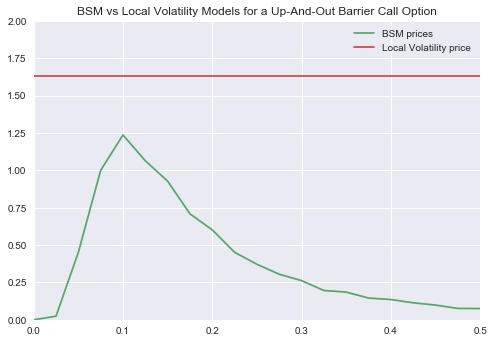

In [116]:
plt.plot(volatilities, barrierMCValues, color='C1', label='BSM prices')
plt.plot(volatilities, [ value for _ in range(len(volatilities)) ], color='C2', 
         label='Local Volatility price')

plt.xlim(0, 0.5)
plt.ylim(0, 2)
plt.title("BSM vs Local Volatility Models for a Up-And-Out Barrier Call Option")
plt.legend()

For any reasonable volatilities, the value (in the BSM world) of the up-and-out barrier call option never exceeds \$1.25. Since \$1.25 is smaller than the \$1.63 value of the local volatility model, there is no implied BSM volatility for this option in this specific local volatility model.